In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np # v1.25.2
import pandas as pd # v2.1.0
import random
from sklearn import metrics #sklearn v1.3.0
from sklearn.metrics import roc_auc_score, make_scorer, log_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.utils import compute_class_weight
import xgboost as xgb # v2.0.0
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials # v0.2.7
from hyperopt.pyll import scope
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Paths for data and results
path2data = 'D:\\__PROJECTS\\__AFbPP\\April2023\\affipred_models\\'
os.chdir(path2data)  # Change current working directory to the data path

# Split train and blind set
NUMBER = 1
path2res = f'D:\\__PROJECTS\\__AFbPP\\April2023\\affipred_models\\fold{NUMBER}\\'

# Define target and features
target = 'two_states'
features = ['GO_number', 'plddt_mean', 'kdHydrophobicity_DELTAmn', 'Volume_(A3)_n', 
            'plddt', 'ASA', 'b62', 'wt_psic', 'mt_psic', 'dpsic']

# Read training data
train = pd.read_csv(f"TRAIN{NUMBER}_CV0423.csv", sep=';')
X = train[features].to_numpy()  # Feature matrix
y = train[target].to_numpy()    # Target vector

In [7]:
evals = 200 # evaulation number of hyperopt
inner_f = 5 # inner fold of nested CV
outer_f = 10 # outer fold of nested CV
RND = 1 # Seed number

In [8]:
savename = "Fold"+ str(NUMBER) + "_" + str(evals) + "evals_nestcv_" + str(outer_f) + "_" + str(inner_f) + "_" + str(RND)

### Nested CV

In [5]:
# Hyperparameter space
space = {
    'objective': 'binary:logistic',
    'n_estimators': hp.choice('n_estimators', range(500, 2000)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'min_child_weight': hp.loguniform('min_child_weight', -5, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0.05, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.01,1)
}

In [6]:
# Create a list to store results of each evaluation step
evaluation_results = []

# Objective function for hyperopt optimization
def objective(params, X, y, cv):
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='auc')
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    avg_score = np.average(scores)
    result = {'loss': -avg_score, 'status': STATUS_OK, 'params': params}
    evaluation_results.append(result)
    return result

# Nested cross-validation function
def nested_cv(X, y, cv_outer, cv_inner, space):
    outer_scores = []
    logloss_scores = []
    best_score = None

    for i, (train_idx, val_idx) in enumerate(cv_outer.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        inner_scores = []
        logloss = []

        for j, (train_idx_inner, val_idx_inner) in enumerate(cv_inner.split(X_train, y_train)):
            X_train_inner, y_train_inner = X_train[train_idx_inner], y_train[train_idx_inner]
            X_val_inner, y_val_inner = X_train[val_idx_inner], y_train[val_idx_inner]

            print(f"outer fold: {i}, inner fold: {j}")
            print(f"size of training, validation in outer: {len(X_train)}, {len(X_val)}")
            print(f"size of training, validation in inner: {len(X_train_inner)}, {len(X_val_inner)}")

            # Hyperparameter tuning with inner cross-validation
            obj_func = partial(objective, X=X_train_inner, y=y_train_inner, cv=cv_inner)
            result = fmin(fn=obj_func, space=space, algo=tpe.suggest, max_evals=evals,
                          rstate=np.random.default_rng(RND))

            # Fit model with best hyperparameters on entire training set
            params = {**space, **result}
            model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='auc')
            model.fit(X_train, y_train)

            # Evaluate model on outer validation set
            score = model.score(X_val, y_val)
            inner_scores.append(score)

            if best_score is None or score > best_score:
                best_score = score
                best_train_indices = train_idx
                best_test_indices = val_idx
                best_model = f"{i}_{j}"

            # Compute log loss on train and test sets
            y_train_pred = model.predict_proba(X_train)
            y_val_pred = model.predict_proba(X_val)
            train_loss = log_loss(y_train, y_train_pred)
            val_loss = log_loss(y_val, y_val_pred)
            logloss.append((train_loss, val_loss))

        logloss_scores.append(logloss)
        outer_scores.append(inner_scores)

    return params, outer_scores, logloss_scores, best_train_indices, best_test_indices, best_score, best_model

# Define outer and inner cross-validation folds
cv_outer = StratifiedKFold(n_splits=outer_f, shuffle=True, random_state=RND)
cv_inner = StratifiedKFold(n_splits=inner_f, shuffle=True, random_state=RND)

try:
    # Perform nested cross-validation
    best_params, scores, logloss, best_train_indices, best_test_indices, best_score, best_model = nested_cv(X, y, cv_outer, cv_inner, space)
    print("Best hyperparameters:", best_params)
    print("AUC from nested cross-validation:")
    for i, outer_fold_scores in enumerate(scores):
        print(f"Outer Fold {i+1}: {outer_fold_scores}")

except Exception as e:
    print("Error: ", e)

outer fold: 0 inner fold: 0
size of training, validation in outer:  44370 4931
size of training, validation in inner:  35496 8874
100%|█████████████████████████████████████████████| 200/200 [40:25<00:00, 12.13s/trial, best loss: -0.9490515906962582]
outer fold: 0 inner fold: 1
size of training, validation in outer:  44370 4931
size of training, validation in inner:  35496 8874
100%|█████████████████████████████████████████████| 200/200 [40:25<00:00, 12.13s/trial, best loss: -0.9521783049353452]
outer fold: 0 inner fold: 2
size of training, validation in outer:  44370 4931
size of training, validation in inner:  35496 8874
100%|█████████████████████████████████████████████| 200/200 [36:54<00:00, 11.07s/trial, best loss: -0.9506536989927321]
outer fold: 0 inner fold: 3
size of training, validation in outer:  44370 4931
size of training, validation in inner:  35496 8874
100%|█████████████████████████████████████████████| 200/200 [31:54<00:00,  9.57s/trial, best loss: -0.9502498619083373]


In [7]:
os.chdir(path2res)
res = pd.DataFrame(evaluation_results)
res.to_csv(str(savename)+"_XGB_hyperopt.csv",sep=";")

### Assessment of AFbPP on Unseen Test Set

In [9]:
best_params=  {'objective': 'binary:logistic', 'n_estimators': 1238, 'learning_rate': 0.0314746135128078, 'max_depth': 6, 'min_child_weight': 0.01583734070323755, 'subsample': 0.9659780431824629, 'colsample_bytree': 0.743783459898558, 'gamma': 0.11015081420657366, 'reg_alpha': 0.06650717342799733, 'reg_lambda': 0.4932198200250238}

In [14]:
# #Fit model on the entire training set
X = train[features]
y = train[target]
# Fit model on the entire training set
xgbs = xgb.XGBClassifier(**best_params, use_label_encoder=False)
xgbs.fit(X, y)

# Export the model and parameters
import pickle
model_path = os.path.join(path2data, f"affipred{NUMBER}_model.pkl")
params_path = os.path.join(path2data, f"affipred{NUMBER}_params.pkl")
with open(model_path, 'wb') as model_file:
    pickle.dump(xgbs, model_file)
with open(params_path, 'wb') as params_file:
    pickle.dump(best_params, params_file)

In [11]:
# Change directory back to the data path
os.chdir(path2data)
blind = pd.read_csv(f"BLIND{NUMBER}_CV0423.csv", sep=';')

# Predict unseen test set
X_blind = blind[features]
y_blind = blind[target]

# Identify known and unknown proteins
known_prot = list(set(train["uniprot"]))
unknown_prot = list(set(blind["uniprot"]))
common = [i for i in known_prot if i in unknown_prot]
known = [i for i in known_prot if i not in common]
unknown = [i for i in unknown_prot if i not in common]

print(f"\033[1mTraining set:\033[0m {len(train)} variants from {len(known)} proteins")
print(f"\033[1mHeld-out test set:\033[0m {len(blind)} variants from {len(unknown)} proteins")
print(f"\033[1mCommon proteins in train and blind sets:\033[0m {len(common)}")

# Make predictions on the blind test set
y_pred = xgbs.predict(X_blind)
y_prob = xgbs.predict_proba(X_blind)[:,1]

# Save predictions to blind DataFrame
blind[f"Affipred{NUMBER}"] = y_pred
blind[f"Affipred_prob{NUMBER}"] = y_prob

# Define evaluation functions
from sklearn import metrics

def evaluation_analysis(true_label, predicted, predictor, dataset):
    eval_results = {
        "dataset": dataset,
        "predictor": predictor,
        "size": len(true_label),
        "f1": metrics.f1_score(true_label, predicted, average='binary'),
        "precision": metrics.precision_score(true_label, predicted),
        "recall": metrics.recall_score(true_label, predicted),
        "accuracy": metrics.accuracy_score(true_label, predicted),
        "matthews_corr": metrics.matthews_corrcoef(true_label, predicted),
        "confusion_matrix": metrics.confusion_matrix(true_label, predicted)
    }
    return eval_results

def evaluation_analysis2(true_label, predicted_score, predictor, dataset):
    eval_results = {
        "dataset": dataset,
        "predictor": predictor,
        "size": len(true_label),
        "auc": metrics.roc_auc_score(true_label, predicted_score),
        "log_loss": metrics.log_loss(true_label, predicted_score)
    }
    return eval_results

# Uncomment to save predictions to CSV
# blind.to_csv(f"pred_BLIND{NUMBER}_CV0423_affi.csv", sep=';')

Training set: 49301 variants from 4912 proteins
Held-out test set: 26029 variants from 2456 proteins
Common proteins in train and blind sets: 0


In [13]:
# Performance assessment
pred_list = ['SIFT_converted_rankscore', 'SIFT4G_converted_rankscore','Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_rankscore', 
           'LRT_converted_rankscore', 'MutationTaster_converted_rankscore', 'MutationAssessor_rankscore', 'FATHMM_converted_rankscore', 
           'PROVEAN_converted_rankscore', 'VEST4_rankscore','MetaSVM_rankscore','MetaLR_rankscore', 'MetaRNN_rankscore', 
           'M-CAP_rankscore','REVEL_rankscore','MutPred_rankscore', 'MVP_rankscore','MPC_rankscore', 'PrimateAI_rankscore', 
            'DEOGEN2_rankscore','BayesDel_addAF_rankscore','BayesDel_noAF_rankscore', 'ClinPred_rankscore', 'LIST-S2_rankscore', 
           'CADD_raw_rankscore', 'DANN_rankscore', 'fathmm-MKL_coding_rankscore','fathmm-XF_coding_rankscore', 'Eigen-raw_coding_rankscore', 
            'Eigen-PC-raw_coding_rankscore', 'GenoCanyon_rankscore', 'integrated_fitCons_rankscore', 'GERP++_RS_rankscore', 
            'phyloP100way_vertebrate_rankscore', 'phyloP30way_mammalian_rankscore','phastCons100way_vertebrate_rankscore', 
            'phastCons30way_mammalian_rankscore', 'SiPhy_29way_logOdds_rankscore','EVmutation_score', 'PolyPhen-2_score',
             'Affipred_prob1','two_states']

#########################################
df1 = blind
df2 = df1.loc[df1["training_info"]=="new"]

### Evaluate on all of the unseen test set
df = df1[pred_list]
perf = []
for p in pred_list:
    dx = df.loc[~df[p].isna()]
    dx[p] =pd.to_numeric(dx[p],downcast="integer")
    d1 = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx[p], p,"all")])
    d2 = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx['Affipred_prob1'], "Affipred",p)])
    d3 = pd.concat([d1,d2])
    perf.append(d3)

dfx = pd.concat(perf)
dfx = dfx.loc[dfx["predictor"]!="two_states"]
dfx1 = dfx

#####################################################

pred_list2=['two_states','Affipred_prob1','rhapsody_prob.']
df = df2[pred_list2]

dx = df.loc[~df["rhapsody_prob."].isna()]
d1 = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx["Affipred_prob1"], "Affipred","rhapsody_prob.")])
d2 = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx["rhapsody_prob."], "rhapsody_prob.","all")])

dfx = pd.concat([d1,d2])
dfx2 = pd.concat([dfx1,dfx])
pd.set_option('display.max_rows', None)

display(dfx2)

os.chdir(path2res)
dfx2.to_csv(str(savename)+"_unseen_auc_logloss.csv", sep=";")

,dataset,predictor,size,auc,log_loss
0,all,SIFT_converted_rankscore,25294,0.875288,0.475869
0,SIFT_converted_rankscore,Affipred,25294,0.920669,0.366542
0,all,SIFT4G_converted_rankscore,25379,0.861682,0.494565
0,SIFT4G_converted_rankscore,Affipred,25379,0.922119,0.365899
0,all,Polyphen2_HDIV_rankscore,25395,0.853325,0.501668
0,Polyphen2_HDIV_rankscore,Affipred,25395,0.922037,0.367520
0,all,Polyphen2_HVAR_rankscore,25395,0.880704,0.466011
0,Polyphen2_HVAR_rankscore,Affipred,25395,0.922037,0.367520
0,all,LRT_converted_rankscore,24462,0.819783,0.529569
0,LRT_converted_rankscore,Affipred,24462,0.921865,0.368942


41


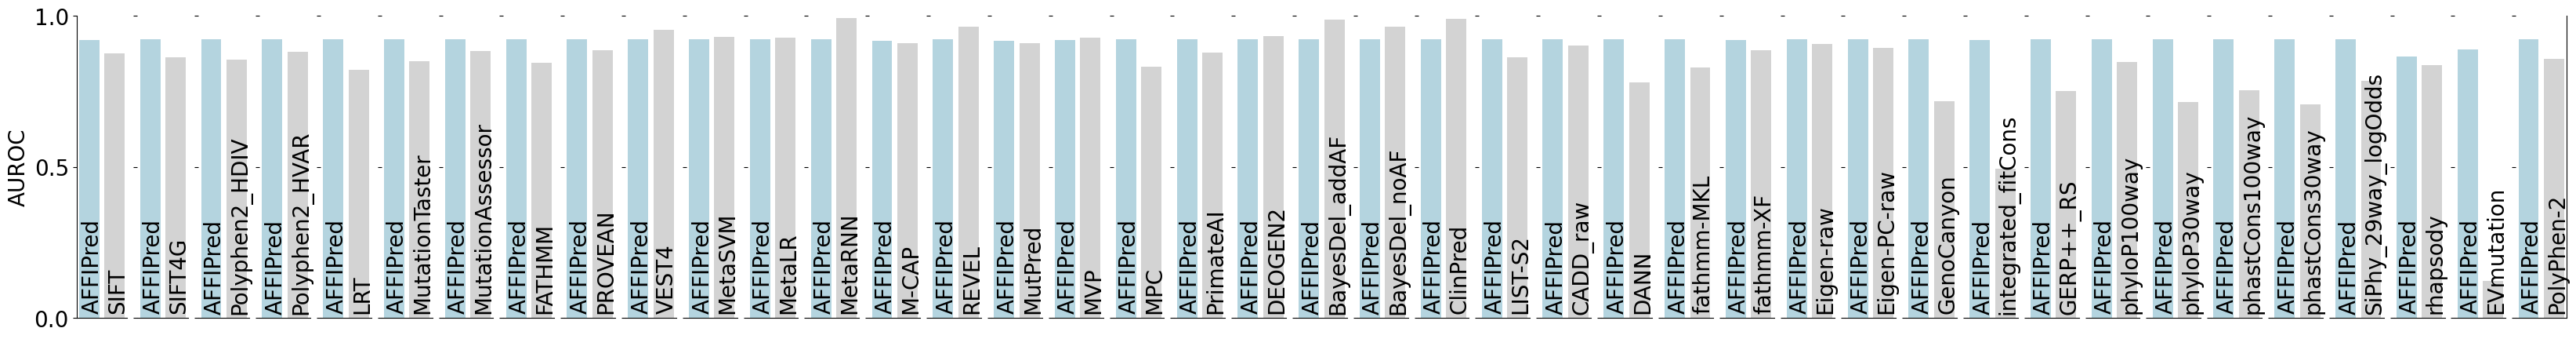

In [12]:
df = dfx2

preds =  ['SIFT_converted_rankscore', 'SIFT4G_converted_rankscore','Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_rankscore', 
         'LRT_converted_rankscore', 'MutationTaster_converted_rankscore', 'MutationAssessor_rankscore', 'FATHMM_converted_rankscore', 
         'PROVEAN_converted_rankscore', 'VEST4_rankscore','MetaSVM_rankscore','MetaLR_rankscore', 'MetaRNN_rankscore', 
         'M-CAP_rankscore','REVEL_rankscore','MutPred_rankscore', 'MVP_rankscore','MPC_rankscore', 'PrimateAI_rankscore', 
          'DEOGEN2_rankscore','BayesDel_addAF_rankscore','BayesDel_noAF_rankscore', 'ClinPred_rankscore', 'LIST-S2_rankscore', 
         'CADD_raw_rankscore', 'DANN_rankscore', 'fathmm-MKL_coding_rankscore','fathmm-XF_coding_rankscore', 'Eigen-raw_coding_rankscore', 
          'Eigen-PC-raw_coding_rankscore', 'GenoCanyon_rankscore', 'integrated_fitCons_rankscore', 'GERP++_RS_rankscore', 
          'phyloP100way_vertebrate_rankscore', 'phyloP30way_mammalian_rankscore','phastCons100way_vertebrate_rankscore', 
          'phastCons30way_mammalian_rankscore', 'SiPhy_29way_logOdds_rankscore','rhapsody_prob.', 'EVmutation_score', 'PolyPhen-2_score'
         ]
print(len(preds))
fig,ax = plt.subplots(1,41, figsize=(41,5),sharex=True,sharey=True)
plt.ylim(0,1)

for i, p in enumerate(preds):
    # print(i)
    dx = df.loc[(df["predictor"]==p)|(df["dataset"]==p)]
    dx=dx.sort_values("predictor",ascending=True)
    sns.barplot(ax = ax[i],data=dx, y ="auc", x="predictor",palette=["lightblue","lightgrey"])
    p = p.replace('_vertebrate_rankscore', '') 
    p = p.replace('_mammalian_rankscore', '') 
    p = p.replace('_converted_rankscore', '') 
    p = p.replace('_coding_rankscore', '')
    p = p.replace('_rankscore', '') 
    p = p.replace('_prob.', '') 
    p = p.replace('_score', '') 

    # p = p.replace('_vertebrate_rankscore', '') 
    # p = p.replace('_mammalian_rankscore', '') 
    # p = p.replace('_vertebrate_rankscore', '') 
    ax[i].set_title("AFFIPred\n"+str(p),rotation=90,fontsize=20,loc='left',x=0.1, y=0.01)
    ax[i].set_ylabel("",rotation=90,fontsize=20)
    ax[0].set_ylabel("AUROC",rotation=90,fontsize=20)
    ax[i].set_xlabel("",rotation=90,fontsize=20)
    ax[i].tick_params(labelsize=20)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)
    ax[0].spines['left'].set_visible(True)
    ax[40].spines['right'].set_visible(True)
    ax[i].set_xticks([])
    ax[i].set_yticks([0,0.5,1.0])
        
plt.savefig(str(savename)+"_blind_auc.png", dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0.01)    
# plt.show()

In [13]:
pred_list = ['SIFT_pred', 'SIFT4G_pred', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred', 'LRT_pred', 'MutationTaster_pred', 
             'MutationAssessor_pred', 'FATHMM_pred', 'PROVEAN_pred', 'MetaSVM_pred', 'MetaLR_pred', 'MetaRNN_pred', 'M-CAP_pred', 
             'PrimateAI_pred', 'DEOGEN2_pred', 'BayesDel_addAF_pred', 'BayesDel_noAF_pred', 'ClinPred_pred', 'LIST-S2_pred', 
             'fathmm-MKL_coding_pred', 'fathmm-XF_coding_pred', 'EVmutation_two_states', 'PolyPhen-2_two_states', 'two_states', 
             'Affipred1']

#####################################################
df1 = blind
df2 = df1.loc[df1["training_info"]=="new"]

### Evaluate on all of the unseen test set
df = df1[pred_list]
perf = []
for p in pred_list:
    dx = df.loc[~df[p].isna()]
    dx[p] =pd.to_numeric(dx[p],downcast="integer")
    d1 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx[p], p,"all")])
    d2 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx['Affipred1'], "Affipred",p)])
    d3 = pd.concat([d1,d2])
    perf.append(d3)

dfx = pd.concat(perf)
dfx = dfx.loc[dfx["predictor"]!="two_states"]
dfx1 = dfx

#####################################################

pred_list2=['two_states','Affipred1','rhapsody_two_states']
df = df2[pred_list2]

dx = df.loc[~df["rhapsody_two_states"].isna()]
d1 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx["Affipred1"], "Affipred","rhapsody_two_states")])
d2 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx["rhapsody_two_states"], "rhapsody_two_states","all")])

dfx = pd.concat([d1,d2])

dfx2 = pd.concat([dfx1,dfx])
display(dfx2)

os.chdir(path2res)
dfx2.to_csv(str(savename)+"_unseen_f1_mcc_acc.csv", sep=";")

,dataset,predictor,size,f1,precision,recall,accuracy,matthews_corr,confusion_matrix
0,all,SIFT_pred,25294,0.753455,0.643011,0.909706,0.753143,0.552194,"[[9509, 5297], [947, 9541]]"
0,SIFT_pred,Affipred,25294,0.793733,0.853865,0.741514,0.840199,0.668770,"[[13475, 1331], [2711, 7777]]"
0,all,SIFT4G_pred,25379,0.763109,0.693250,0.848626,0.777139,0.566877,"[[10613, 4031], [1625, 9110]]"
0,SIFT4G_pred,Affipred,25379,0.798943,0.859642,0.746251,0.841128,0.673276,"[[13336, 1308], [2724, 8011]]"
0,all,Polyphen2_HDIV_pred,25395,0.745536,0.628988,0.915098,0.733451,0.523307,"[[8710, 5849], [920, 9916]]"
0,Polyphen2_HDIV_pred,Affipred,25395,0.798871,0.861859,0.744463,0.840047,0.672204,"[[13266, 1293], [2769, 8067]]"
0,all,Polyphen2_HVAR_pred,25395,0.777899,0.694028,0.884828,0.784406,0.590360,"[[10332, 4227], [1248, 9588]]"
0,Polyphen2_HVAR_pred,Affipred,25395,0.798871,0.861859,0.744463,0.840047,0.672204,"[[13266, 1293], [2769, 8067]]"
0,all,LRT_pred,23342,0.763889,0.660529,0.905599,0.755848,0.551842,"[[8424, 4738], [961, 9219]]"
0,LRT_pred,Affipred,23342,0.802129,0.865446,0.747446,0.839174,0.672975,"[[11979, 1183], [2571, 7609]]"


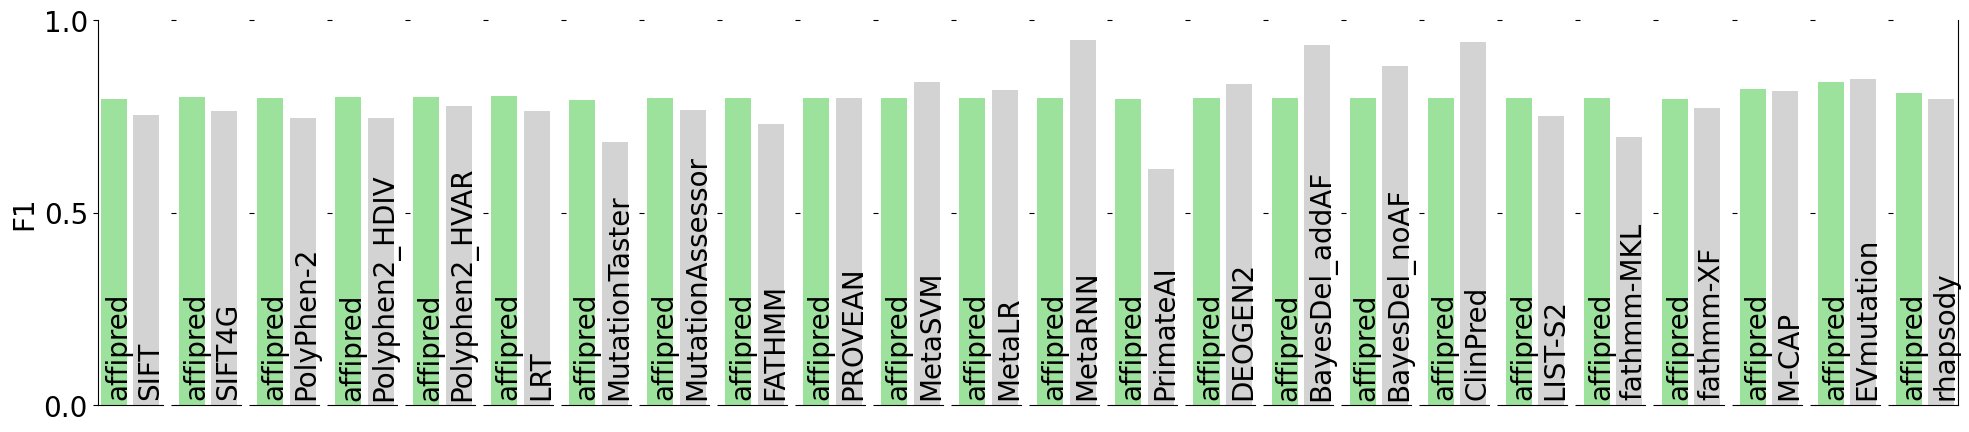

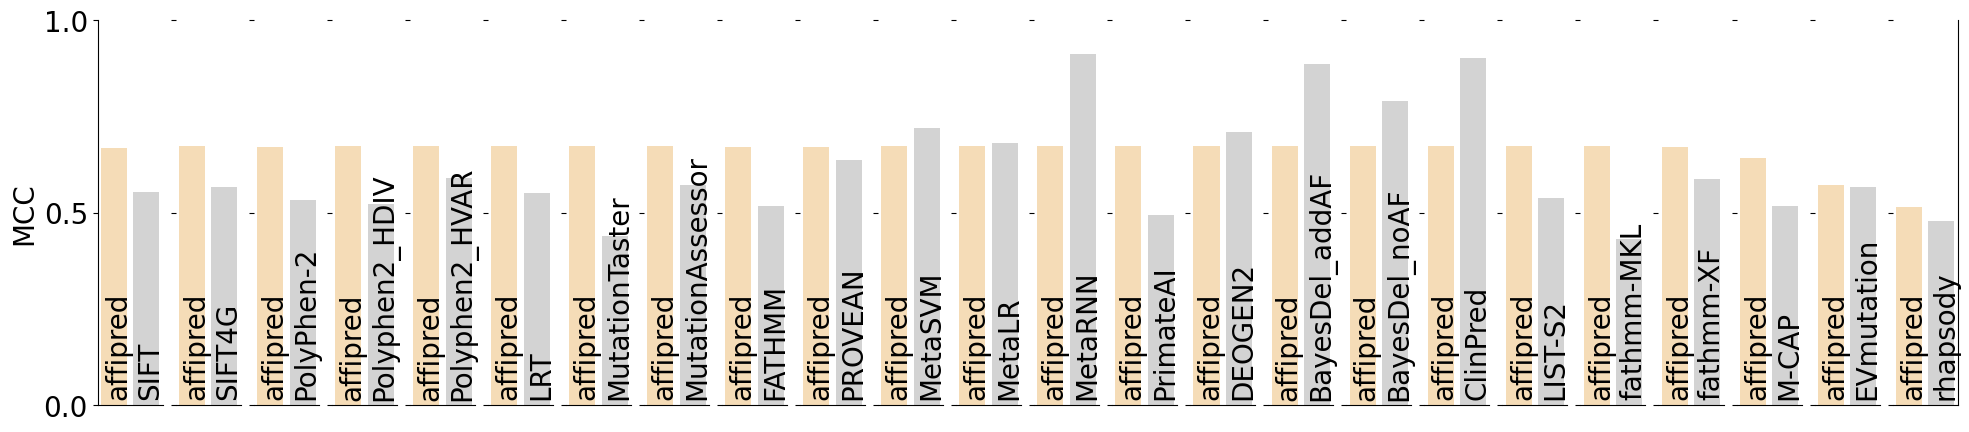

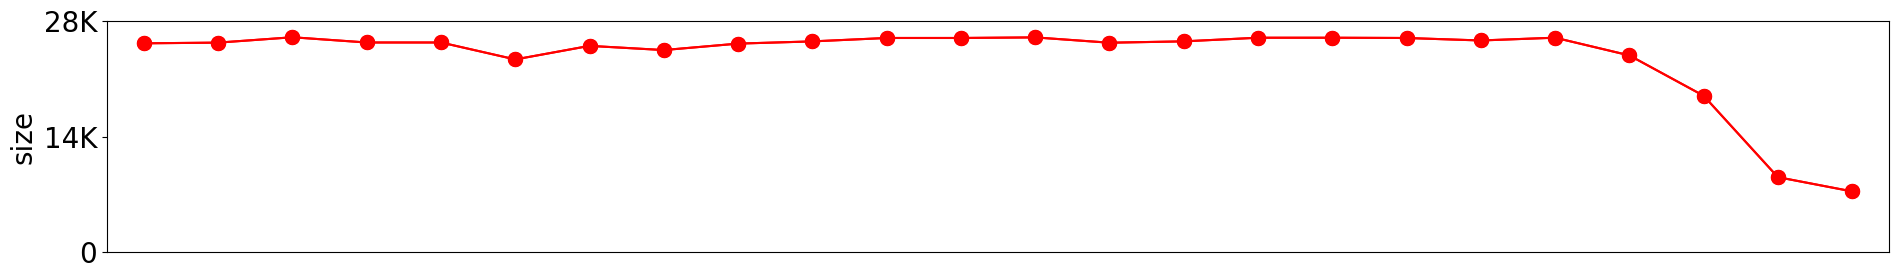

In [14]:
df = dfx2

preds =  ['SIFT_pred','SIFT4G_pred',"PolyPhen-2_two_states",'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred','LRT_pred',
          'MutationTaster_pred', 'MutationAssessor_pred', 'FATHMM_pred',  'PROVEAN_pred',  'MetaSVM_pred','MetaLR_pred', 
          'MetaRNN_pred', 'PrimateAI_pred','DEOGEN2_pred','BayesDel_addAF_pred','BayesDel_noAF_pred',
          'ClinPred_pred','LIST-S2_pred', 'fathmm-MKL_coding_pred', 'fathmm-XF_coding_pred', 'M-CAP_pred', "EVmutation_two_states",
          'rhapsody_two_states']
# print(len(preds))

fig,ax = plt.subplots(1,24, figsize=(24,5),sharex=True,sharey=True)
plt.ylim(0,0.9)

for i, p in enumerate(preds):
    dx = df.loc[(df["predictor"]==p)|(df["dataset"]==p)]
    dx=dx.sort_values("predictor")
    sns.barplot(ax = ax[i],data=dx,y ="f1", x="predictor",palette=["lightgreen","lightgrey"])
    p = p.replace('_pred', '') 
    p = p.replace('_two_states', '') 
    p = p.replace('_coding', '') 
    ax[i].set_title("affipred\n"+str(p),rotation=90,fontsize=20,loc='left',x=0.1, y=0.01)
    ax[i].set_ylabel("",rotation=90,fontsize=20)
    ax[0].set_ylabel("F1",rotation=90,fontsize=20)
    ax[i].set_xlabel("",rotation=90,fontsize=20)
    ax[i].tick_params(labelsize=20)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)  
    ax[0].spines['left'].set_visible(True)
    ax[23].spines['right'].set_visible(True) 
    ax[i].set_xticks([])
    ax[i].set_yticks([0,0.5,1.0])
        
plt.savefig(str(savename)+"_blind_f1.png", dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0.01)    
    
plt.show()

fig,ax = plt.subplots(1,24, figsize=(24,5),sharex=True,sharey=True)
plt.ylim(0,0.9)

for i, p in enumerate(preds):
    dx = df.loc[(df["predictor"]==p)|(df["dataset"]==p)]
    dx=dx.sort_values("predictor")
    sns.barplot(ax = ax[i],data=dx,y ="matthews_corr", x="predictor",palette=["navajowhite","lightgrey"])
    p = p.replace('_pred', '') 
    p = p.replace('_two_states', '') 
    p = p.replace('_coding', '') 
    ax[i].set_title("affipred\n"+str(p),rotation=90,fontsize=20,loc='left',x=0.1, y=0.01)
    ax[i].set_ylabel("",rotation=90,fontsize=20)
    ax[0].set_ylabel("MCC",rotation=90,fontsize=20)
    ax[i].set_xlabel("",rotation=90,fontsize=20)
    ax[i].tick_params(labelsize=20)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)
    ax[0].spines['left'].set_visible(True)
    ax[23].spines['right'].set_visible(True)
    ax[i].set_xticks([])
    ax[i].set_yticks([0,0.5,1.0])
        
plt.savefig(str(savename)+"_blind_mcc.png", dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0.01)    

plt.show()

s = []
for i, p in enumerate(preds):
    dx = df.loc[(df["predictor"]==p)|(df["dataset"]==p)]
    dx=dx.sort_values("predictor")
    s.append(dx["size"])
# print(s)
fig,ax = plt.subplots(1,1, figsize=(23,3),sharex=True,sharey=True)
plt.ylim(0,28000)
plt.xlim(-0.5,23.5)
plt.plot(s,color="red",marker=".",markersize=20)
plt.tick_params(labelsize=20)
plt.yticks([0,14000,28000],["0","14K","28K"])
plt.xticks([])
plt.ylabel("size",rotation=90,fontsize=20)
        
plt.savefig(str(savename)+"_blind_size.png", dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0.01)    

plt.show()

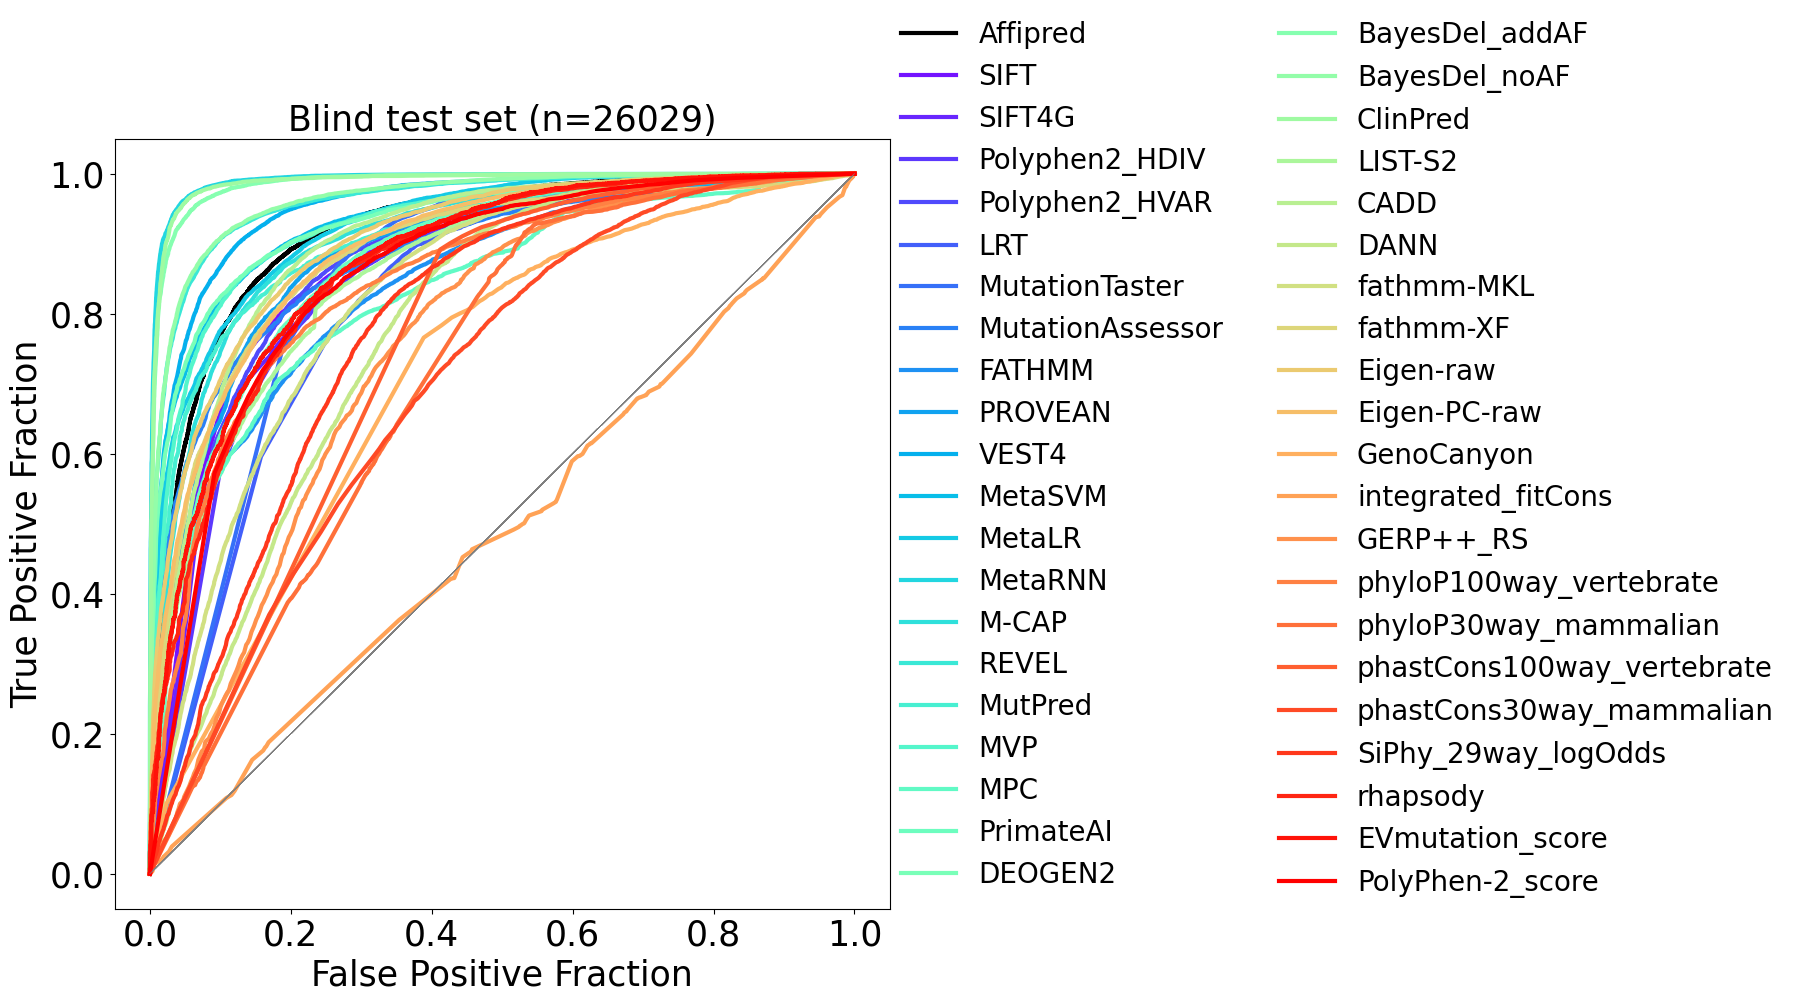

In [15]:
df1 = blind
df1['EVmutation_score']=1-df1['EVmutation_score']
predscores = ['SIFT_converted_rankscore', 'SIFT4G_converted_rankscore','Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_rankscore', 
           'LRT_converted_rankscore', 'MutationTaster_converted_rankscore', 'MutationAssessor_rankscore', 'FATHMM_converted_rankscore', 
           'PROVEAN_converted_rankscore', 'VEST4_rankscore','MetaSVM_rankscore','MetaLR_rankscore', 'MetaRNN_rankscore', 
           'M-CAP_rankscore','REVEL_rankscore','MutPred_rankscore', 'MVP_rankscore','MPC_rankscore', 'PrimateAI_rankscore', 
            'DEOGEN2_rankscore','BayesDel_addAF_rankscore','BayesDel_noAF_rankscore', 'ClinPred_rankscore', 'LIST-S2_rankscore', 
           'CADD_raw_rankscore', 'DANN_rankscore', 'fathmm-MKL_coding_rankscore','fathmm-XF_coding_rankscore', 'Eigen-raw_coding_rankscore', 
            'Eigen-PC-raw_coding_rankscore', 'GenoCanyon_rankscore', 'integrated_fitCons_rankscore', 'GERP++_RS_rankscore', 
            'phyloP100way_vertebrate_rankscore', 'phyloP30way_mammalian_rankscore','phastCons100way_vertebrate_rankscore', 
            'phastCons30way_mammalian_rankscore', 'SiPhy_29way_logOdds_rankscore','rhapsody_prob.', 'EVmutation_score', 'PolyPhen-2_score']

ls = ["two_states","Affipred_prob1"]
predscores = ls + predscores
# print(predscores)
# predscores = [i for i in predscores if "_score" not in i]
# df1 = blind
df2 = df1.loc[df1["training_info"]=="new"]

### Evaluate on all of the unseen test set
df = df1[predscores]
predscores = [i for i in predscores if "two_states" not in i ]

prednames = []
for p in predscores:
    head, sep, tail = p.partition('_r')
    head, sep, tail = head.partition('_co')
    head, sep, tail = head.partition('_prob')
    prednames.append(head)

colors = []
for i in range(len(predscores)-1):
    color = plt.cm.seismic(np.linspace(0, 1, len(predscores)-1))
    colors.append(color)

rocvals = []
for i, p in enumerate(predscores):
    # print(p)
    color = plt.cm.rainbow(np.linspace(0, 1, len(predscores)))

    dx = df.loc[~df[p].isna()]
    fpr, tpr, thres = metrics.roc_curve(dx["two_states"], dx[p])
    dr = {"name":p,"fpr":fpr,"tpr":tpr,"scores":thres}
    dr = pd.DataFrame(dr)

    if prednames[i] == "Affipred":
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr,label=prednames[i],color="black",linewidth=3)
    else:

        plt.plot(fpr,tpr,label=prednames[i],color=color[i],linewidth=3,linestyle="-")
        plt.plot([0,0.5,1],[0,0.5,1],color ="grey",linestyle="-",linewidth=0.5)
        plt.ylabel('True Positive Fraction',fontsize=25)
        plt.xlabel('False Positive Fraction',fontsize=25)
        plt.tick_params(axis='both', which='both', labelsize=25)
        plt.legend(loc =(1,0),ncol= 2,frameon=False,fontsize=20)
        plt.title("Blind test set (n="+str(len(df1))+")",fontsize=25,x=0.5, y=1.0)
os.chdir(path2res)
plt.savefig(str(savename) +'_ROCblindtest.png', facecolor='w', bbox_inches='tight', pad_inches=0.01)

plt.show()

### Proteome Prediction

In [20]:
aa_list = ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y"]
for aa in aa_list:
    os.chdir('D:\\__PROJECTS\\__AFbPP\\April2023\\affipred_models\\DB\\')
    df = pd.read_csv(str(aa)+"_DB_proteome_123d_feats_11060872.csv",sep=";")

    X = df[features]
    y_pred = xgbs.predict(X)
    y_prob = xgbs.predict_proba(X)[:,1]
    df["Affipred"+str(NUMBER)] = y_pred
    df["Affipred_prob"+str(NUMBER)] = y_prob
    df.to_csv("DB_10feat_AFbPP_fold"+str(NUMBER)+"_evals"+str(evals)+"_mutant_"+str(aa)+".csv",sep=";")
    print(aa)
#     os.remove(str(aa)+"_DB_proteome_123d_feats_11060872",sep=";")


A
C
D
E
F
G
H
I
K
L
M
N
P
Q
R
S
T
V
W
Y
